In [87]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Definicion de variables. 
## Objetivo del proyecto es el promedio de tiempo que hay desde la aceptacion del pedido hasta la entrega al cliente. 
>- names = Nombres
>- orders = Pedidos
>- customers = Clientes
>- items = Artículos 
>- payments = Pagos
>- reviews = Reseñas
>- products = Productos
>- sellers = Vendedores
>- geolocation = Geolocalización

In [88]:
nombres =  pd.read_csv('../data/raw/product_category_name_translation.csv')
pedidos = pd.read_csv('../data/raw/olist_orders_dataset.csv')
clientes = pd.read_csv('../data/raw/olist_customers_dataset.csv')
artículos = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
pagos = pd.read_csv('../data/raw/olist_order_payments_dataset.csv')
reseñas = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')
productos = pd.read_csv('../data/raw/olist_products_dataset.csv')
vendedores = pd.read_csv('../data/raw/olist_sellers_dataset.csv')
geolocalización = pd.read_csv('../data/raw/olist_geolocation_dataset.csv')

In [89]:
date_cols = ["order_purchase_timestamp", "order_delivered_carrier_date", "order_approved_at", "order_delivered_customer_date", "order_estimated_delivery_date"]

for col in date_cols:
    pedidos[col] = pd.to_datetime(pedidos[col], errors="coerce")

pedidos["delivery_time_days"] = (pedidos["order_delivered_customer_date"] - pedidos["order_approved_at"]).dt.total_seconds() / (3600 * 24)
pedidos = pedidos[(pedidos["delivery_time_days"].notna()) &(pedidos["delivery_time_days"] >= 0)]

In [90]:
df = pedidos.merge(clientes, on="customer_id", how="left")

In [91]:
items_agg = artículos.groupby("order_id").agg(total_items=("order_item_id", "count"), total_price=("price", "sum"), total_freight=("freight_value", "sum")).reset_index()
df = df.merge(items_agg, on='order_id', how='left')

In [92]:
payments_agg = pagos.groupby("order_id").agg(payment_value=("payment_value", "sum"),payment_installments=("payment_installments", "max")).reset_index()
df = df.merge(payments_agg, on="order_id", how="left")

In [93]:
reviews_agg = reseñas.groupby("order_id").agg(review_score=("review_score", "mean")).reset_index()
df = df.merge(reviews_agg, on="order_id", how="left")

In [94]:
df.shape

(96401, 19)

In [95]:
geo_agg = geolocalización.groupby("geolocation_zip_code_prefix").agg(geo_lat=("geolocation_lat", "mean"),geo_lng=("geolocation_lng", "mean")).reset_index()
df = df.merge(geo_agg, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")

In [96]:
df.drop(columns=["geolocation_zip_code_prefix"], inplace=True)

In [97]:
df.isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       1
order_delivered_customer_date      0
order_estimated_delivery_date      0
delivery_time_days                 0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
total_items                        0
total_price                        0
total_freight                      0
payment_value                      1
payment_installments               1
review_score                     644
geo_lat                          264
geo_lng                          264
dtype: int64

In [98]:
df = df.drop_duplicates(subset=["order_id"])

In [99]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,...,customer_city,customer_state,total_items,total_price,total_freight,payment_value,payment_installments,review_score,geo_lat,geo_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,7c396fd4830fd04220f754e42b4e5bff,...,sao paulo,SP,1,29.99,8.72,38.71,1.0,4.0,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,af07308b275d755c9edb36a90c618231,...,barreiras,BA,1,118.70,22.76,141.46,1.0,4.0,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,3a653a41f6f9fc3d2a113cf8398680e8,...,vianopolis,GO,1,159.90,19.22,179.12,3.0,5.0,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.196331,7c142cf63193a1473d2e66489a9ae977,...,sao goncalo do amarante,RN,1,45.00,27.20,72.20,1.0,5.0,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.830938,72632f0f9dd73dfee390c9b22eb56dd6,...,santo andre,SP,1,19.90,8.72,28.62,1.0,5.0,-23.676370,-46.514627


In [100]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time_days', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'total_items', 'total_price',
       'total_freight', 'payment_value', 'payment_installments',
       'review_score', 'geo_lat', 'geo_lng'],
      dtype='object')

### Definicion de variables: 

- order_id = Identificador único del pedido.
- customer_id = Identificador del cliente en ese pedido concreto.
- customer_unique_id = Identificador único real del cliente.
- order_status = Estado final del pedido
- order_purchase_timestamp = Fecha y hora en la que el cliente realiza la compra.
- order_approved_at = Momento en que el pago es aprobado.
- order_delivered_carrier_date = Fecha en que el pedido se entrega al transportista.
- order_delivered_customer_date = Fecha real de entrega al cliente.
- order_estimated_delivery_date = Fecha prometida al cliente.
- customer_zip_code_prefix = Prefijo del código postal del cliente.
- customer_city = Ciudad del cliente.
- customer_state = Estado / región del cliente.
- total_items = Número total de productos en el pedido.
- total_price = Suma del precio de todos los productos del pedido.
- total_freight = Coste total de envío
- payment_value = Monto total pagado por el cliente.
- payment_installments = Número de cuotas del pago.
- review_score = Puntuación de la reseña (1 a 5)
- geo_lat = Latitud media del código postal del cliente.
- geo_lng = Longitud media del código postal del cliente.

In [101]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,customer_unique_id,...,customer_city,customer_state,total_items,total_price,total_freight,payment_value,payment_installments,review_score,geo_lat,geo_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,7c396fd4830fd04220f754e42b4e5bff,...,sao paulo,SP,1,29.99,8.72,38.71,1.0,4.0,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,af07308b275d755c9edb36a90c618231,...,barreiras,BA,1,118.70,22.76,141.46,1.0,4.0,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,3a653a41f6f9fc3d2a113cf8398680e8,...,vianopolis,GO,1,159.90,19.22,179.12,3.0,5.0,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.196331,7c142cf63193a1473d2e66489a9ae977,...,sao goncalo do amarante,RN,1,45.00,27.20,72.20,1.0,5.0,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.830938,72632f0f9dd73dfee390c9b22eb56dd6,...,santo andre,SP,1,19.90,8.72,28.62,1.0,5.0,-23.676370,-46.514627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96396,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009,6359f309b166b0196dbf7ad2ac62bb5a,...,sao jose dos campos,SP,1,72.00,13.08,85.08,3.0,5.0,-23.178000,-45.883818
96397,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.185637,da62f9e57a76d978d02ab5362c509660,...,praia grande,SP,1,174.90,20.10,195.00,3.0,4.0,-24.001500,-46.449864
96398,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.847234,737520a9aad80b3fbbdad19b66b37b30,...,nova vicosa,BA,1,205.99,65.02,271.01,5.0,5.0,-17.898358,-39.373630
96399,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.080938,5097a5312c8b157bb7be58ae360ef43c,...,japuiba,RJ,2,359.98,81.18,441.16,4.0,2.0,-22.562825,-42.694574


### Analisis graficos de las latitudes y longitudes. 

In [102]:
df['customer_city'].value_counts()

customer_city
sao paulo                15019
rio de janeiro            6602
belo horizonte            2697
brasilia                  2071
curitiba                  1486
                         ...  
taperuaba                    1
senador jose porfirio        1
miraguai                     1
teixeira                     1
itiquira                     1
Name: count, Length: 4085, dtype: int64

In [103]:
df['order_status'].value_counts()

order_status
delivered    96395
canceled         6
Name: count, dtype: int64

In [104]:
df.dropna(inplace=True)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95492 entries, 0 to 96400
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       95492 non-null  object        
 1   customer_id                    95492 non-null  object        
 2   order_status                   95492 non-null  object        
 3   order_purchase_timestamp       95492 non-null  datetime64[ns]
 4   order_approved_at              95492 non-null  datetime64[ns]
 5   order_delivered_carrier_date   95492 non-null  datetime64[ns]
 6   order_delivered_customer_date  95492 non-null  datetime64[ns]
 7   order_estimated_delivery_date  95492 non-null  datetime64[ns]
 8   delivery_time_days             95492 non-null  float64       
 9   customer_unique_id             95492 non-null  object        
 10  customer_zip_code_prefix       95492 non-null  int64         
 11  customer_city       

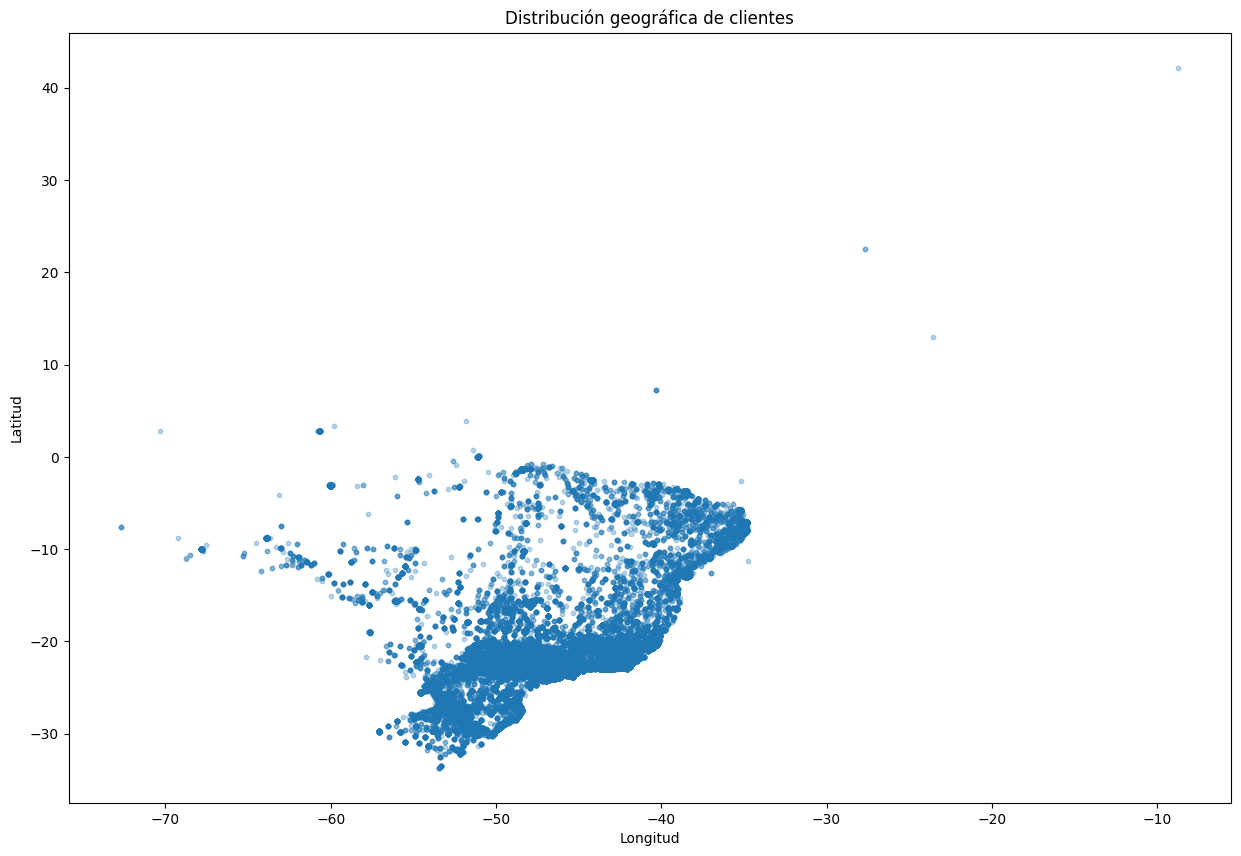

In [106]:
plt.figure(figsize=(15, 10))
plt.scatter(df["geo_lng"], df["geo_lat"], alpha=0.3, s=10)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución geográfica de clientes")
plt.show()

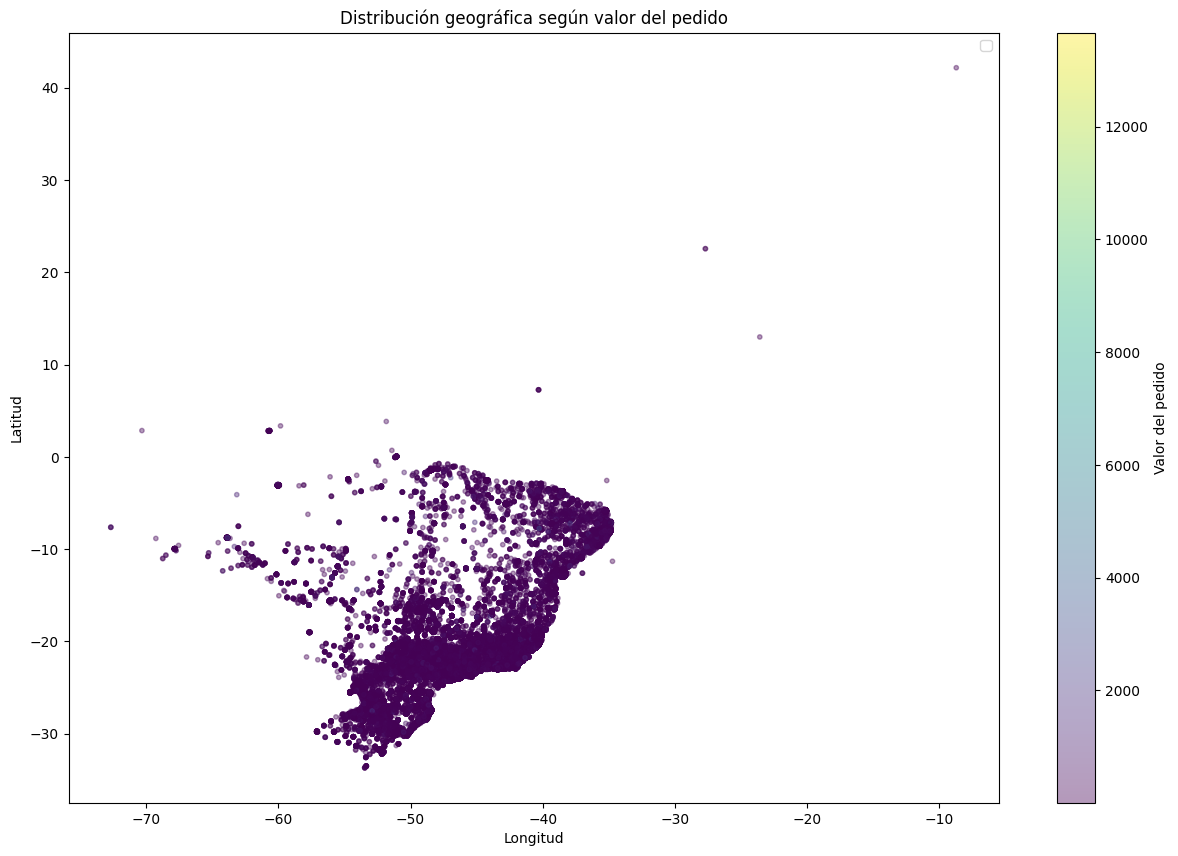

In [107]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(df["geo_lng"], df["geo_lat"], c=df["payment_value"], alpha=0.4, s=10)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución geográfica según valor del pedido")
plt.colorbar(scatter, label="Valor del pedido")
plt.legend()
plt.show()


## Analisis de mi target. 

In [ ]:
df["delivery_time_days"].head()

0     8.429144
1    12.502292
2     9.382708
3    13.196331
4     2.830938
Name: delivery_time_days, dtype: float64

In [ ]:
df["delivery_time_days"].describe()

count    95492.000000
mean        12.087609
std          9.420914
min          0.007662
25%          6.302902
50%          9.835457
75%         15.107859
max        208.338808
Name: delivery_time_days, dtype: float64

In [112]:
df["delivery_time_days"].median()

np.float64(9.835457175925926)

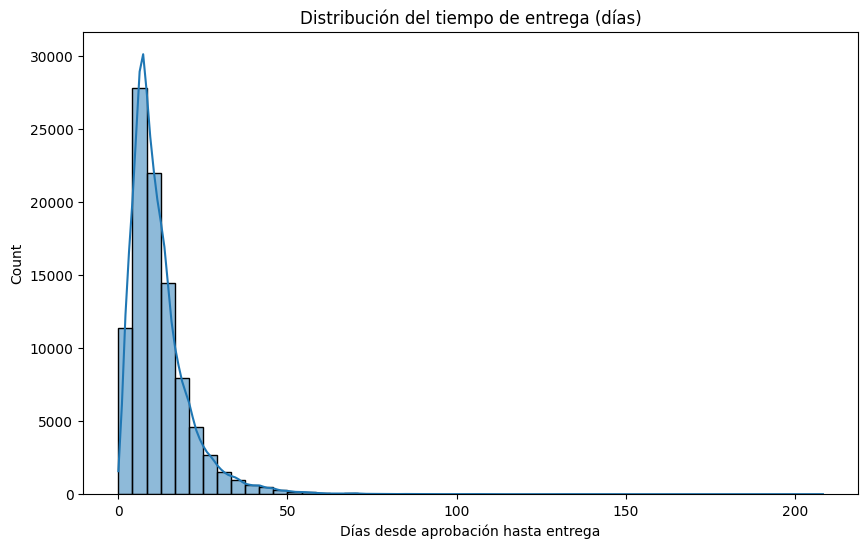

In [110]:
plt.figure(figsize=(10,6))
sns.histplot(df["delivery_time_days"], bins=50, kde=True)
plt.title("Distribución del tiempo de entrega (días)")
plt.xlabel("Días desde aprobación hasta entrega")
plt.show()

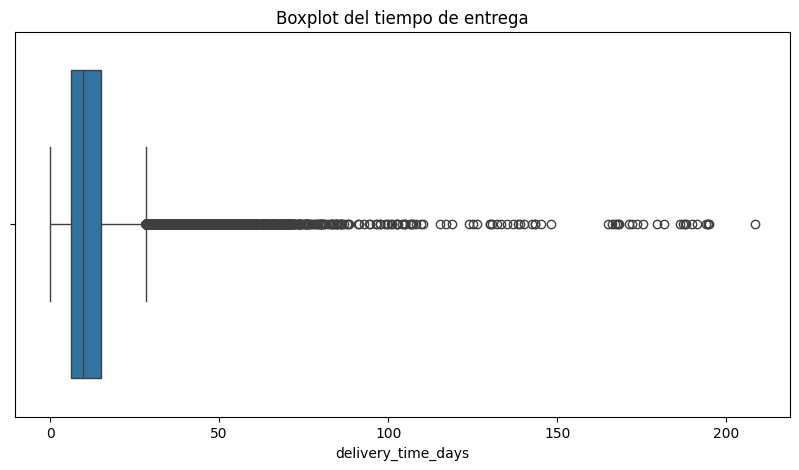

In [113]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["delivery_time_days"])
plt.title("Boxplot del tiempo de entrega")
plt.show()